In [2]:
import torch
from torch_geometric.utils import (negative_sampling, remove_self_loops,
                                   add_self_loops)
EPS = 1e-15
MAX_LOGSTD = 10

class InnerProductDecoder(torch.nn.Module):
    r"""The inner product decoder from the `"Variational Graph Auto-Encoders"
    <https://arxiv.org/abs/1611.07308>`_ paper

    .. math::
        \sigma(\mathbf{Z}\mathbf{Z}^{\top})

    where :math:`\mathbf{Z} \in \mathbb{R}^{N \times d}` denotes the latent
    space produced by the encoder."""
    def forward(self, z, edge_index, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into edge probabilities for
        the given node-pairs :obj:`edge_index`.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        value = (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)
        return torch.sigmoid(value) if sigmoid else value


    def forward_all(self, z, sigmoid=True):
        r"""Decodes the latent variables :obj:`z` into a probabilistic dense
        adjacency matrix.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            sigmoid (bool, optional): If set to :obj:`False`, does not apply
                the logistic sigmoid function to the output.
                (default: :obj:`True`)
        """
        adj = torch.matmul(z, z.t())
        return torch.sigmoid(adj) if sigmoid else adj



class GAE(torch.nn.Module):
    r"""The Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper based on user-defined encoder and decoder models.

    Args:
        encoder (Module): The encoder module.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, decoder=None):
        super(GAE, self).__init__()
        self.encoder = encoder
        self.decoder = InnerProductDecoder() if decoder is None else decoder
        GAE.reset_parameters(self)

    def reset_parameters(self):
        reset(self.encoder)
        reset(self.decoder)


    def encode(self, *args, **kwargs):
        r"""Runs the encoder and computes node-wise latent variables."""
        return self.encoder(*args, **kwargs)


    def decode(self, *args, **kwargs):
        r"""Runs the decoder and computes edge probabilities."""
        return self.decoder(*args, **kwargs)


    def recon_loss(self, z, pos_edge_index, neg_edge_index=None):
        r"""Given latent variables :obj:`z`, computes the binary cross
        entropy loss for positive edges :oenbj:`pos_edge_index` and negative
        sampled edges.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to train against.
            neg_edge_index (LongTensor, optional): The negative edges to train
                against. If not given, uses negative sampling to calculate
                negative edges. (default: :obj:`None`)
        """

        pos_loss = -torch.log(
            self.decoder(z, pos_edge_index, sigmoid=True) + EPS).mean()

        # Do not include self-loops in negative samples
        pos_edge_index, _ = remove_self_loops(pos_edge_index)
        pos_edge_index, _ = add_self_loops(pos_edge_index)
        if neg_edge_index is None:
            neg_edge_index = negative_sampling(pos_edge_index, z.size(0))
        neg_loss = -torch.log(1 -
                              self.decoder(z, neg_edge_index, sigmoid=True) +
                              EPS).mean()

        return pos_loss + neg_loss


    def test(self, z, pos_edge_index, neg_edge_index):
        r"""Given latent variables :obj:`z`, positive edges
        :obj:`pos_edge_index` and negative edges :obj:`neg_edge_index`,
        computes area under the ROC curve (AUC) and average precision (AP)
        scores.

        Args:
            z (Tensor): The latent space :math:`\mathbf{Z}`.
            pos_edge_index (LongTensor): The positive edges to evaluate
                against.
            neg_edge_index (LongTensor): The negative edges to evaluate
                against.
        """
        from sklearn.metrics import roc_auc_score, average_precision_score

        pos_y = z.new_ones(pos_edge_index.size(1))
        neg_y = z.new_zeros(neg_edge_index.size(1))
        y = torch.cat([pos_y, neg_y], dim=0)

        pos_pred = self.decoder(z, pos_edge_index, sigmoid=True)
        neg_pred = self.decoder(z, neg_edge_index, sigmoid=True)
        pred = torch.cat([pos_pred, neg_pred], dim=0)
        
        y, pred = y.detach().cpu().numpy(), pred.detach().cpu().numpy()

        return roc_auc_score(y, pred), average_precision_score(y, pred)



class VGAE(GAE):
    r"""The Variational Graph Auto-Encoder model from the
    `"Variational Graph Auto-Encoders" <https://arxiv.org/abs/1611.07308>`_
    paper.

    Args:
        encoder (Module): The encoder module to compute :math:`\mu` and
            :math:`\log\sigma^2`.
        decoder (Module, optional): The decoder module. If set to :obj:`None`,
            will default to the
            :class:`torch_geometric.nn.models.InnerProductDecoder`.
            (default: :obj:`None`)
    """
    def __init__(self, encoder, decoder=None):
        super(VGAE, self).__init__(encoder, decoder)

    def reparametrize(self, mu, logstd):
        if self.training:
            return mu + torch.randn_like(logstd) * torch.exp(logstd)
        else:
            return mu
    
    def encode(self, *args, **kwargs):
        """"""
        self.__mu__, self.__logstd__ = self.encoder(*args, **kwargs)
        self.__logstd__ = self.__logstd__.clamp(max=MAX_LOGSTD)
        z = self.reparametrize(self.__mu__, self.__logstd__)
        return z

    def kl_loss(self, mu=None, logstd=None):
        r"""Computes the KL loss, either for the passed arguments :obj:`mu`
        and :obj:`logstd`, or based on latent variables from last encoding.

        Args:
            mu (Tensor, optional): The latent space for :math:`\mu`. If set to
                :obj:`None`, uses the last computation of :math:`mu`.
                (default: :obj:`None`)
            logstd (Tensor, optional): The latent space for
                :math:`\log\sigma`.  If set to :obj:`None`, uses the last
                computation of :math:`\log\sigma^2`.(default: :obj:`None`)
        """
        mu = self.__mu__ if mu is None else mu
        logstd = self.__logstd__ if logstd is None else logstd.clamp(
            max=MAX_LOGSTD)
        return -0.5 * torch.mean(
            torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))

In [3]:
import torch
from torch.autograd.grad_mode import F
from torch_geometric.data import Data
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges
from torch_geometric.nn import VGAE

import scipy.sparse as sp
import numpy as np
import networkx as nx

class SimuData():
    """Simulate graph data"""
    def __init__(self, p=0.5, n_node=10, n_graph=30):
        self.n_node = n_node
        self.n_graph = n_graph
        self.p = p

    def simu_adj_wgh(self):
        adj_list = []

        for i in range(self.n_graph):
            ## zero matrix
            A = torch.zeros(self.n_node, self.n_node)

            # first five nodes weights: uniform(0,1)A[:5,:5] = W
            W = torch.rand(5,5)

            ## symmetric
            i, j = torch.triu_indices(5, 5)
            W[i, j] = W.T[i, j]

            A[:5,:5] = W
            adj_list.append(A)  

        return adj_list

    def simu_adj_diag(self):
        adj_list = []

        for i in range(self.n_graph):
            A = torch.eye(self.n_node)
            adj_list.append(A)  

        return adj_list

    def simu_adj_m(self):
        """generating adjacency matrix"""
        adj_wgh = self.simu_adj_wgh()
        #adj_wgh = self.simu_adj_diag()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj>=1-self.p] = 1
            adj[adj<1-self.p] = 0
            for i in range(adj.shape[0]):
                adj[i, i] = 0
            adj_m_list.append(adj)    
        return adj_m_list

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.simu_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)

        return dataset

    def get_x_feature(self):
        x = torch.arange(self.n_node)
        x_onehot = torch.eye(self.n_node)[x,:] 

        return torch.FloatTensor(x_onehot)


class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Encoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True) 
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)


transform = T.Compose([
            T.NormalizeFeatures(),
            T.RandomLinkSplit(num_val=0, num_test=0, is_undirected=True,
                            split_labels=True, add_negative_train_samples=False),])

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
import numpy as np
import scipy.sparse as sp
from scipy.sparse import csr_matrix


class LoadData():
    """Load graph data"""
    def __init__(self, file_path, samples, n_node=38):
        self.samples = samples
        self.file_path = file_path
        self.nSample = len(samples)
        self.n_node = n_node

    def get_adj_wgh(self):
        """generating adjacency matrix"""
        adj_orig_list =[]
        for sample in self.samples:
            f_name = self.file_path + ".".join([sample])
            adj   = np.asarray(pd.read_csv(f_name, index_col = 0, iterator = False))
            adj_orig_list.append(adj)    

        return adj_orig_list

    def get_adj_label(self):
        adj_m = self.get_adj_m()
        adj_label_list =[]
        
        for _, adj in enumerate(adj_m):
            adj_label = adj + sp.eye(adj.shape[0])
            adj_label = sparse_to_tuple(sp.coo_matrix(adj_label))
            #adj_label = sparse_to_tuple(adj_label)
            adj_label = torch.sparse.FloatTensor(torch.LongTensor(adj_label[0].T), 
                            torch.FloatTensor(adj_label[1]), 
                            torch.Size(adj_label[2]))
            adj_label_list.append(adj_label)
        return adj_label_list

    def get_adj_norm(self):
        adj_m = self.get_adj_m()
        adj_norm_list =[]

        for _, adj in enumerate(adj_m):
            adj_norm = preprocess_graph(adj)
            adj_norm = torch.sparse.FloatTensor(torch.LongTensor(adj_norm[0].T), 
                            torch.FloatTensor(adj_norm[1]), 
                            torch.Size(adj_norm[2]))
            adj_norm_list.append(adj_norm)

        return adj_norm_list

    def get_adj_m(self):
        adj_wgh = self.get_adj_wgh()
        adj_m_list =[]
        for _, adj in enumerate(adj_wgh):
            adj[adj>0] = 1
            for i in range(38):
                adj[i, i] = 0
            for i in range(38):
                for j in range(38):
                    if adj[i, j] == 1:
                        adj[j, i] = 1
            adj_m_list.append(adj)    
        return adj_m_list

    def get_feature(self):
        """generating feature matrix X"""
        adj_wgh = self.get_adj_wgh()
        x_list = []
        for _, adj in enumerate(adj_wgh):
            x_feature  = adj
            x_feature  = csr_matrix(x_feature)
            x_feature  = sparse_to_tuple(x_feature)
            x_feature  = torch.sparse.FloatTensor(torch.LongTensor(x_feature[0].T), 
                            torch.FloatTensor(x_feature[1]), 
                            torch.Size(x_feature[2]))
            x_list.append(x_feature)
        return x_list

    def get_x_feature(self):
        x = torch.arange(self.n_node)
        x_onehot = torch.eye(self.n_node)[x,:] 

        return torch.FloatTensor(x_onehot)   

    def graph_dataset(self):
        dataset =[]
        simu_adj = self.get_adj_m()

        for _, adj in enumerate(simu_adj):
            edge_index_temp = sp.coo_matrix(adj)
            indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
            edge_index_A = torch.LongTensor(indices) 
            x = self.get_x_feature()
            data = Data(x=x, edge_index=edge_index_A)
            dataset.append(data)
        return dataset


def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape

def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    
    return sparse_to_tuple(adj_normalized)

from os import walk

def get_filename(mypath):
    f = []
    for (dirpath, dirnames, filenames) in walk(mypath):
        f.extend(filenames)
        break
    return f



In [308]:
adj = simu_adj_list[1]
indices = np.vstack((edge_index_temp.row, edge_index_temp.col))
edge_index_temp = sp.coo_matrix(adj)
np.vstack((edge_index_temp.row, edge_index_temp.col))
edge_index_A = torch.LongTensor(indices) 
edge_index_A

tensor([[0, 0, 1, 1, 1, 3, 3, 4],
        [1, 3, 0, 3, 4, 0, 1, 1]])

In [126]:
samples = get_filename("./ipfdata/")
ipfdata = LoadData(file_path="./ipfdata/", samples=samples)
ipfdata.graph_dataset()

[Data(x=[38, 38], edge_index=[2, 978]),
 Data(x=[38, 38], edge_index=[2, 1044]),
 Data(x=[38, 38], edge_index=[2, 1112]),
 Data(x=[38, 38], edge_index=[2, 908]),
 Data(x=[38, 38], edge_index=[2, 1004]),
 Data(x=[38, 38], edge_index=[2, 1088]),
 Data(x=[38, 38], edge_index=[2, 930]),
 Data(x=[38, 38], edge_index=[2, 912]),
 Data(x=[38, 38], edge_index=[2, 720]),
 Data(x=[38, 38], edge_index=[2, 820]),
 Data(x=[38, 38], edge_index=[2, 958]),
 Data(x=[38, 38], edge_index=[2, 614]),
 Data(x=[38, 38], edge_index=[2, 932]),
 Data(x=[38, 38], edge_index=[2, 654]),
 Data(x=[38, 38], edge_index=[2, 906]),
 Data(x=[38, 38], edge_index=[2, 966]),
 Data(x=[38, 38], edge_index=[2, 806]),
 Data(x=[38, 38], edge_index=[2, 930]),
 Data(x=[38, 38], edge_index=[2, 844]),
 Data(x=[38, 38], edge_index=[2, 840]),
 Data(x=[38, 38], edge_index=[2, 676]),
 Data(x=[38, 38], edge_index=[2, 628]),
 Data(x=[38, 38], edge_index=[2, 684]),
 Data(x=[38, 38], edge_index=[2, 532]),
 Data(x=[38, 38], edge_index=[2, 766

In [7]:
simu_graph = SimuData(n_graph=30)
dataset = simu_graph.graph_dataset()
n_node = simu_graph.n_node

out_channels = 10
num_features = n_node

model = VGAE(Encoder(num_features, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
epochs = 10000

for epoch in range(epochs):
    loss_total = 0
    optimizer.zero_grad()
    
    for i in range(len(dataset)):
        train_data, val_data, test_data = transform(dataset[i])
        z = model.encode(train_data.x, train_data.edge_index)
        loss =10 *model.recon_loss(z, train_data.edge_index)
        loss = loss + (1 /num_features) * model.kl_loss()
        loss_total += loss

    loss_avg = loss_total/len(dataset)
    loss_avg.backward()
    optimizer.step()
    print(str(epoch)+str(loss_avg))

0tensor(26.2423, grad_fn=<DivBackward0>)
1tensor(28.6024, grad_fn=<DivBackward0>)
2tensor(28.0201, grad_fn=<DivBackward0>)
3tensor(27.3966, grad_fn=<DivBackward0>)
4tensor(26.8433, grad_fn=<DivBackward0>)
5tensor(21.8432, grad_fn=<DivBackward0>)
6tensor(26.3008, grad_fn=<DivBackward0>)
7tensor(27.4654, grad_fn=<DivBackward0>)
8tensor(23.0838, grad_fn=<DivBackward0>)
9tensor(25.0707, grad_fn=<DivBackward0>)
10tensor(24.9221, grad_fn=<DivBackward0>)
11tensor(26.5165, grad_fn=<DivBackward0>)
12tensor(25.5646, grad_fn=<DivBackward0>)
13tensor(24.4107, grad_fn=<DivBackward0>)
14tensor(25.9789, grad_fn=<DivBackward0>)
15tensor(25.8323, grad_fn=<DivBackward0>)
16tensor(27.3115, grad_fn=<DivBackward0>)
17tensor(27.0096, grad_fn=<DivBackward0>)
18tensor(25.2773, grad_fn=<DivBackward0>)
19tensor(27.5759, grad_fn=<DivBackward0>)
20tensor(27.9475, grad_fn=<DivBackward0>)
21tensor(26.8689, grad_fn=<DivBackward0>)
22tensor(27.3339, grad_fn=<DivBackward0>)
23tensor(24.9840, grad_fn=<DivBackward0>)
24

In [4]:
simu_graph = SimuData(n_graph=30)
dataset = simu_graph.graph_dataset()
n_node = simu_graph.n_node

out_channels = 10
num_features = n_node

os.chdir('C:\\Users\\Ji Qi\\Documents\\GitHub\\ST-Aim3')
os.getcwd()
PATH = 'vgae_model_for_simulation.pth'
#torch.save(model, PATH)

model = torch.load(PATH)
model.eval()

VGAE(
  (encoder): Encoder(
    (conv1): GCNConv(10, 20)
    (conv_mu): GCNConv(20, 10)
    (conv_logstd): GCNConv(20, 10)
  )
  (decoder): InnerProductDecoder()
)

In [22]:
# get mu and logstd 

mu_list_in_data = []
logstd_list_in_data = []
for i in range(len(dataset)):
    train_data = dataset[i]
    mu, logstd = Encoder(n_node, out_channels)(train_data.x, train_data.edge_index)
    mu_list_in_data.append(np.asarray(mu.detach()))
    logstd_list_in_data.append(np.asarray(logstd.detach()))

mu_list_reshape = []
logstd_list_reshape = []
n = len(dataset)
for i in range(n):
    mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))
    logstd_list_reshape.append(logstd_list_in_data[i].reshape((out_channels * n_node)))

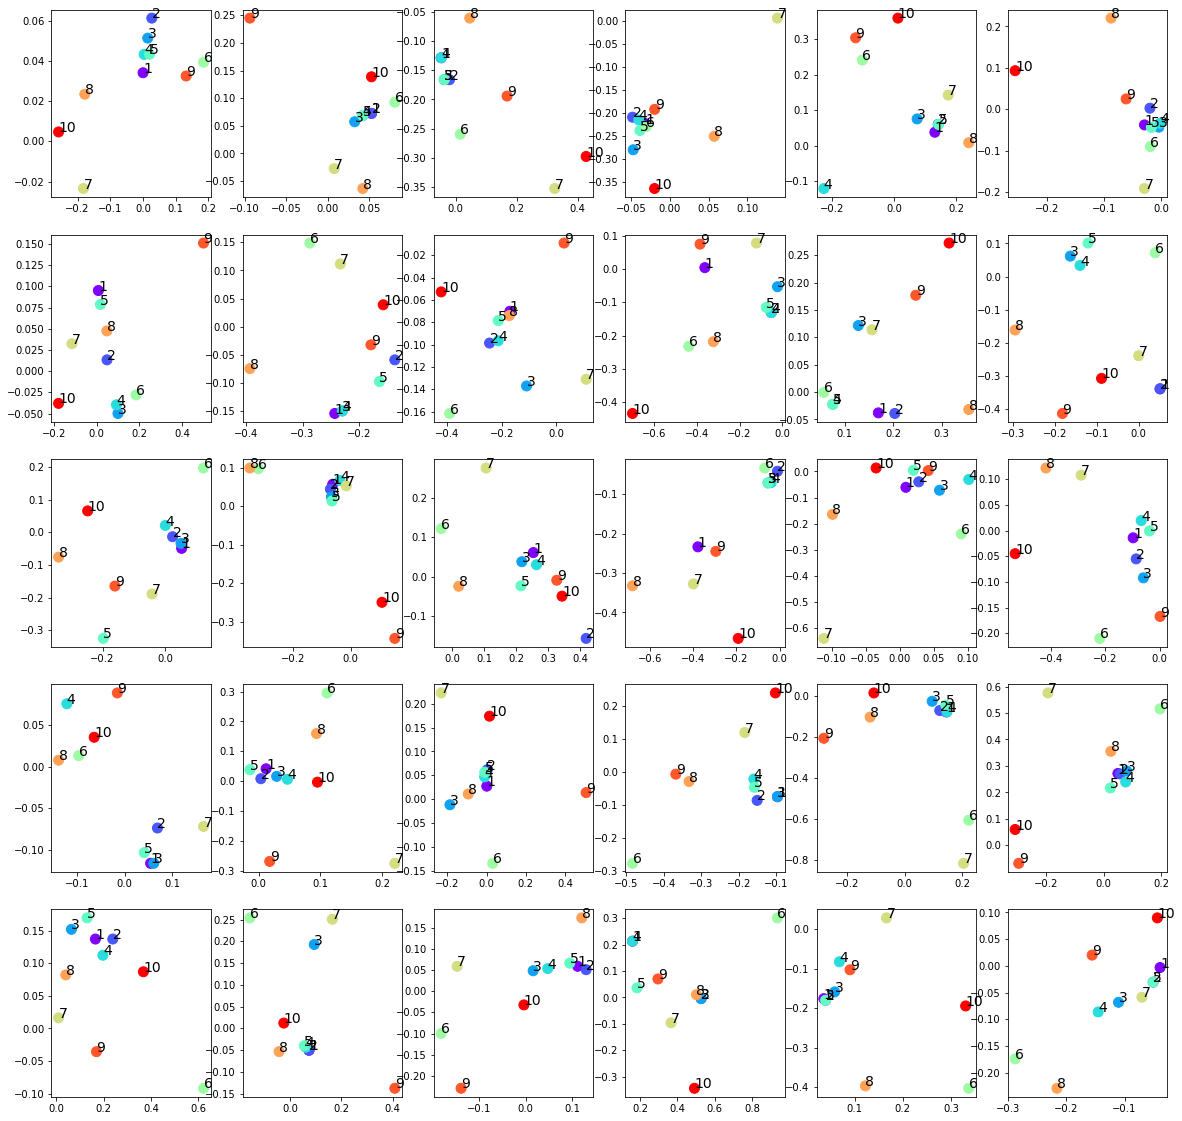

In [23]:
# input data scatter 
import matplotlib.pyplot as plt
def plot_mu_graph(mu):
    
    n_node = mu.shape[0]
    annotations = [str(i+1) for i in range(n_node)]
    colors = plt.cm.rainbow(np.linspace(0, 1, n_node))
    plt.scatter(mu[:,0],mu[:,1],c=colors, s=100)
    
    for i, label in enumerate(annotations):
        plt.annotate(label, (mu[i,0], mu[i,1]), fontsize=14)

        
plt.subplots(figsize=(20,20))

for graph_i in range(30):
    plt.subplot(5, 6, graph_i+1)
    plot_mu_graph(mu_list_in_data[graph_i])

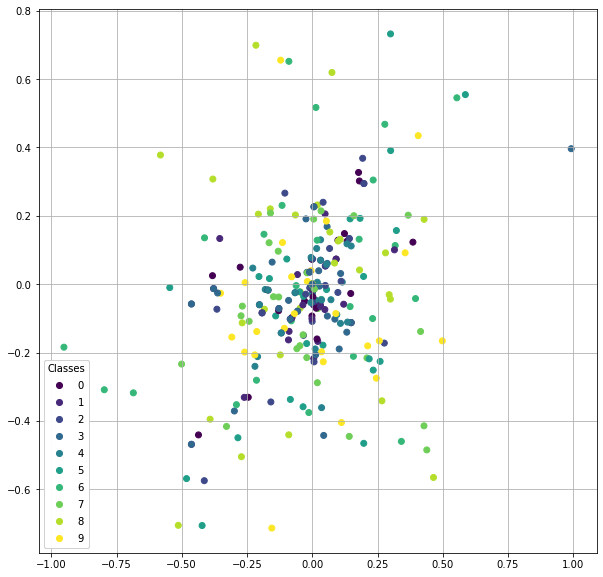

In [39]:
# original data mu scatter
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
def plot_scatter_for_mu(mu_list):
    column_names = ["x", "y"]
    mu_for_plot = pd.DataFrame(columns = column_names, data=np.vstack(mu_list_i))
    mu_for_plot["label"] = list(range(10))*len(mu_list)
    x = mu_for_plot["x"]
    y = mu_for_plot["y"]
    c = mu_for_plot["label"]
    fig, ax = plt.subplots(figsize=(10,10))
    scatter = ax.scatter(x, y, c=c)

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    ax.add_artist(legend1)

    plt.grid()
    plt.show()

plot_scatter_for_mu(mu_list_in_data)

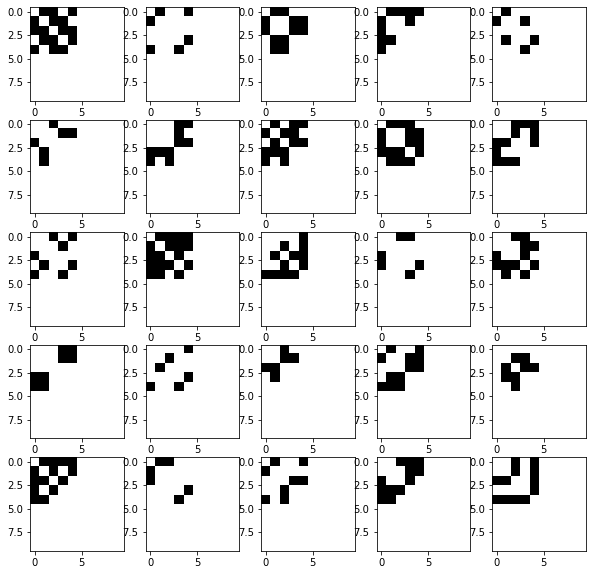

In [24]:
# original adj matrices

import matplotlib.pyplot as plt
fig, ax = plt.subplots(5, 5, figsize=(10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(simu_graph.simu_adj_m()[i], cmap="Greys")

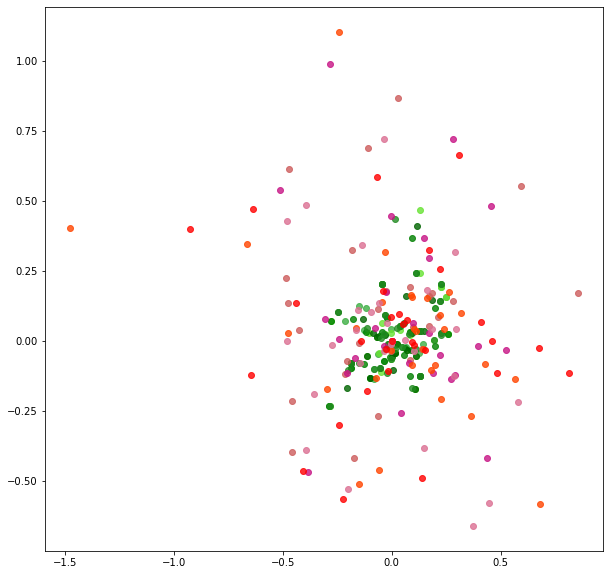

In [ ]:
# original data first 5 vs. last 5
simu_graph = SimuData(n_graph=30)
dataset = simu_graph.graph_dataset()
n_node = simu_graph.n_node

colors = ['#3DAE43', '#67E332','#008000', '#006400', '#228B22',
          '#CD5C5C','#C71585', '#FF4500', '#DB7093', '#FF0000']
mu_list = []
logstd_list = []
for i in range(len(dataset)):
    train_data = dataset[i]
    mu, logstd = Encoder(n_node, out_channels)(train_data.x, train_data.edge_index)
    mu_list.append(np.asarray(mu.detach()))
    logstd_list.append(np.asarray(logstd.detach()))

plt.figure(figsize=(10,10))
for node_i in range(n_node):
    
    node_mu = np.empty((0, 2))
    for graph_i in range(len(mu_list)):
    
        node_mu = np.vstack((node_mu, mu_list[graph_i][node_i, :]))
    
    plt.scatter(node_mu[:,0],node_mu[:,1], c=colors[node_i],alpha=0.8)

plt.show()

In [25]:
# Gaussian distribution for generating mu
# get mu and logstd 

mu_list_in_data = []
logstd_list_in_data = []
for i in range(len(dataset)):
    train_data = dataset[i]
    mu, logstd = Encoder(n_node, out_channels)(train_data.x, train_data.edge_index)
    mu_list_in_data.append(np.asarray(mu.detach()))
    logstd_list_in_data.append(np.asarray(logstd.detach()))

mu_list_reshape = []
logstd_list_reshape = []
n = len(dataset)
for i in range(n):
    mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))
    logstd_list_reshape.append(logstd_list_in_data[i].reshape((out_channels * n_node)))
    
import scipy.stats as stats
data_mu = np.zeros((n, out_channels * n_node))
data_logstd = np.zeros((n, out_channels * n_node))
for i in range(n):
    data_mu[i, :] = mu_list_reshape[i]
    data_logstd[i, :] = logstd_list_reshape[i]

from sklearn.mixture import GaussianMixture

gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
gm_mu.weights_[0] = 1    

C:\Users\Ji Qi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [21]:
# got mean and cov for mu generating distribution
means_normal = gm_mu.means_
cov_normal = gm_mu.covariances_
means_normal = np.asarray(means_normal.tolist()[0])
cov_normal = np.asarray(cov_normal.tolist()[0])*0.01

NameError: name 'gm_mu' is not defined

In [19]:
#construct edge index
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp

In [20]:
print(means_normal.reshape((n_node,out_channels)))
print(cov_normal)

NameError: name 'means_normal' is not defined

In [26]:
def sample_adj_mat(filter_value=0.75, filter_eye=True):
    model.__mu__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal,cov=cov_normal)).reshape((n_node,out_channels)))
    z = model.__mu__
    model.decode(z, edge_index)
    adj_mat = np.zeros((n_node, n_node))
    for i in range(n_node*n_node):
        adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
    adj_mat[adj_mat < filter_value] = 0
    if filter_eye:
        for i in range(adj_mat.shape[0]):
            adj_mat[i,i]=0
    return adj_mat, model.__mu__

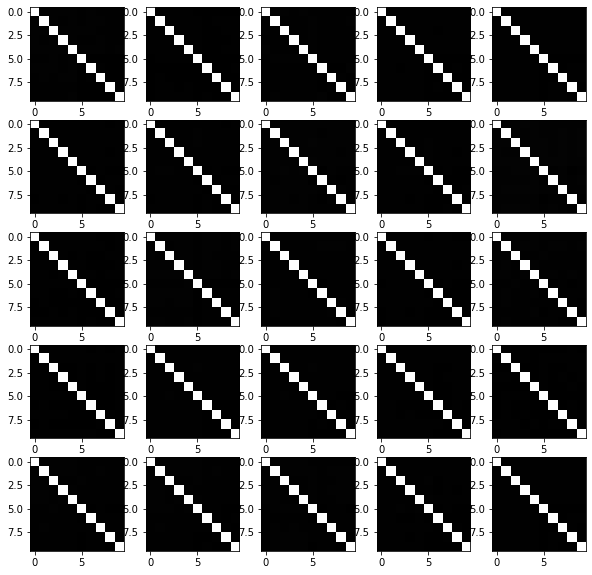

In [14]:
# generate adjacency matrices

import matplotlib.pyplot as plt
fig, ax = plt.subplots(5, 5, figsize=(10,10))
adj_mat_list = []
mu_list = []
for i in range(25):
    plt.subplot(5, 5, i+1)
    adj_mat, mu_sample = sample_adj_mat(filter_value=0)
    adj_mat_list.append(adj_mat)
    mu_list.append(mu_sample.detach().numpy())
    plt.imshow(adj_mat, cmap="Greys")

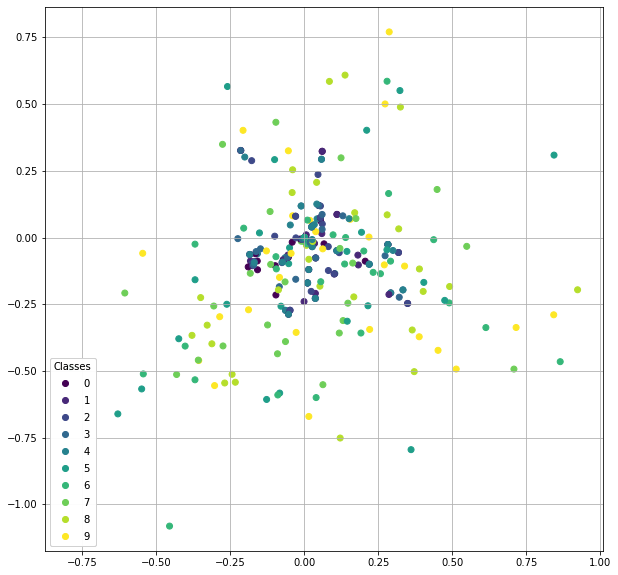

In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
def plot_scatter_for_mu(mu_list):
    column_names = ["x", "y"]
    mu_for_plot = pd.DataFrame(columns = column_names, data=np.vstack(mu_list))
    mu_for_plot["label"] = list(range(10))*30
    x = mu_for_plot["x"]
    y = mu_for_plot["y"]
    c = mu_for_plot["label"]
    fig, ax = plt.subplots(figsize=(10,10))
    scatter = ax.scatter(x, y, c=c)

    # produce a legend with the unique colors from the scatter
    legend1 = ax.legend(*scatter.legend_elements(),
                        loc="lower left", title="Classes")
    ax.add_artist(legend1)

    plt.grid()
    plt.show()

plot_scatter_for_mu(mu_list_in_data)

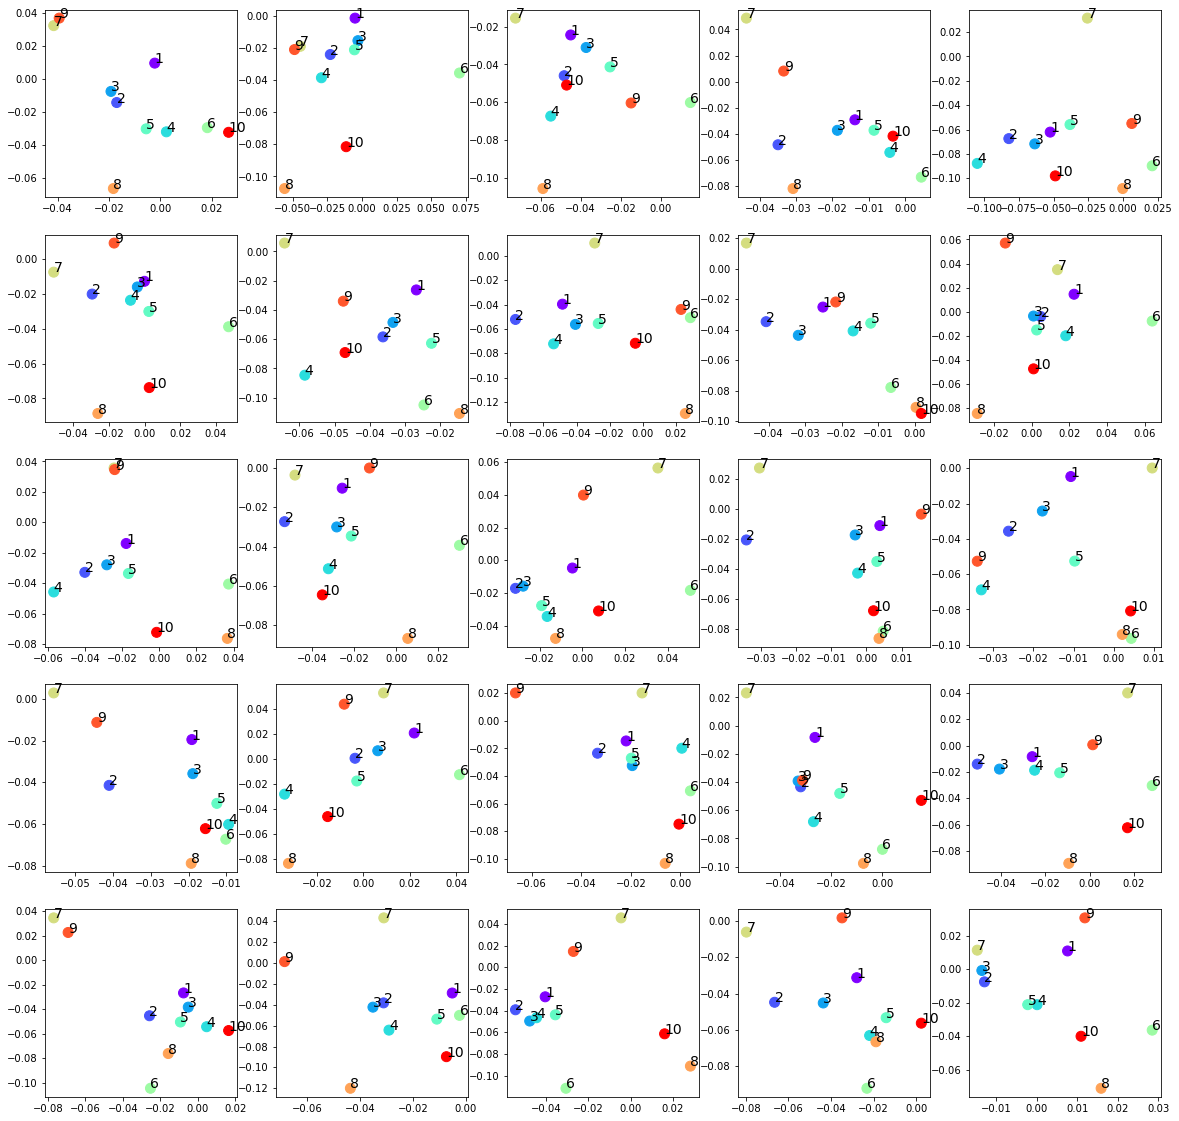

In [59]:
plt.subplots(figsize=(20,20))

for graph_i in range(25):
    plt.subplot(5, 5, graph_i+1)
    plot_mu_graph(mu_list[graph_i])

In [16]:
def compute_centrality(mat):
    return (np.sum(mat, axis=0)/mat.shape[0])

ipf_centrality = []
for i in range(len(samples)):
    ipf_centrality.append(compute_centrality(ipfdata.get_adj_m()[i]))

NameError: name 'samples' is not defined

In [27]:
def compute_centrality(mat):
    return (np.sum(mat, axis=0)/mat.shape[0])

In [28]:
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp

adj_list = []

for i in range(len(dataset)):
        train_data, val_data, test_data = transform(dataset[i])
        z = model.encode(train_data.x, train_data.edge_index)
        adj_mat = np.zeros((n_node, n_node))
        for j in range(n_node*n_node):
            adj_mat[int(edge_index[0, j]), int(edge_index[1, j])] = (model.decode(z, edge_index)[j].detach().numpy()).item()
        adj_list.append(adj_mat)

In [127]:
dataset = ipfdata.graph_dataset()
n_node = 38

out_channels = 2
num_features = n_node

model = VGAE(Encoder(num_features, out_channels))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 10000

for epoch in range(epochs):
    loss_total = 0
    optimizer.zero_grad()
    
    for i in range(len(dataset)):
        train_data, val_data, test_data = transform(dataset[i])
        z = model.encode(train_data.x, train_data.edge_index)
        loss = model.recon_loss(z, train_data.pos_edge_label_index)
        loss = loss + (1 /num_features) * 0.01* model.kl_loss()
        loss_total += loss

    loss_avg = loss_total/len(dataset)
    loss_avg.backward()
    optimizer.step()
    print(str(epoch)+str(loss_avg))

0tensor(1.7101, grad_fn=<DivBackward0>)
1tensor(1.6717, grad_fn=<DivBackward0>)
2tensor(1.6809, grad_fn=<DivBackward0>)
3tensor(1.6341, grad_fn=<DivBackward0>)
4tensor(1.6181, grad_fn=<DivBackward0>)
5tensor(1.5894, grad_fn=<DivBackward0>)
6tensor(1.5553, grad_fn=<DivBackward0>)
7tensor(1.5433, grad_fn=<DivBackward0>)
8tensor(1.5161, grad_fn=<DivBackward0>)
9tensor(1.4978, grad_fn=<DivBackward0>)
10tensor(1.4853, grad_fn=<DivBackward0>)
11tensor(1.4639, grad_fn=<DivBackward0>)
12tensor(1.4503, grad_fn=<DivBackward0>)
13tensor(1.4648, grad_fn=<DivBackward0>)
14tensor(1.4357, grad_fn=<DivBackward0>)
15tensor(1.4330, grad_fn=<DivBackward0>)
16tensor(1.4285, grad_fn=<DivBackward0>)
17tensor(1.4177, grad_fn=<DivBackward0>)
18tensor(1.4149, grad_fn=<DivBackward0>)
19tensor(1.4098, grad_fn=<DivBackward0>)
20tensor(1.4084, grad_fn=<DivBackward0>)
21tensor(1.4063, grad_fn=<DivBackward0>)
22tensor(1.4013, grad_fn=<DivBackward0>)
23tensor(1.4025, grad_fn=<DivBackward0>)
24tensor(1.4014, grad_fn=<

In [158]:
os.chdir('C:\\Users\\Ji Qi\\Documents\\GitHub\\ST-Aim3')
os.getcwd()
PATH = 'vgae_model_ipfdata.pth'
torch.save(model, PATH)

model = torch.load(PATH)
model.eval()

VGAE(
  (encoder): Encoder(
    (conv1): GCNConv(38, 4)
    (conv_mu): GCNConv(4, 2)
    (conv_logstd): GCNConv(4, 2)
  )
  (decoder): InnerProductDecoder()
)

In [139]:
mu_list_in_data = []
logstd_list_in_data = []
for i in range(len(dataset)):
    train_data = dataset[i]
    mu, logstd = Encoder(n_node, out_channels)(train_data.x, train_data.edge_index)
    mu_list_in_data.append(np.asarray(mu.detach()))
    logstd_list_in_data.append(np.asarray(logstd.detach()))

mu_list_reshape = []
logstd_list_reshape = []
n = len(dataset)
for i in range(n):
    mu_list_reshape.append(mu_list_in_data[i].reshape((out_channels * n_node)))
    logstd_list_reshape.append(logstd_list_in_data[i].reshape((out_channels * n_node)))

In [140]:
# Gaussian distribution for generating mu
import scipy.stats as stats
data_mu = np.zeros((n, out_channels * n_node))
data_logstd = np.zeros((n, out_channels * n_node))
for i in range(n):
    data_mu[i, :] = mu_list_reshape[i]
    data_logstd[i, :] = logstd_list_reshape[i]

from sklearn.mixture import GaussianMixture

gm_mu = GaussianMixture(n_components=1, random_state=0).fit(data_mu)
gm_mu.weights_[0] = 1    

C:\Users\Ji Qi\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [141]:
# got mean and cov for mu generating distribution
means_normal = gm_mu.means_
cov_normal = gm_mu.covariances_
means_normal = np.asarray(means_normal.tolist()[0])
cov_normal = np.asarray(cov_normal.tolist()[0])*0.01

In [143]:
#construct edge index
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp

In [160]:
def sample_adj_mat(filter_value=0.75, filter_eye=True):
    model.__mu__ = torch.from_numpy((np.random.multivariate_normal(mean=means_normal,cov=cov_normal)).reshape((n_node,out_channels)))
    z = model.__mu__
    model.decode(z, edge_index)
    adj_mat = np.zeros((n_node, n_node))
    for i in range(n_node*n_node):
        adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
    adj_mat[adj_mat < filter_value] = 0
    if filter_eye:
        for i in range(adj_mat.shape[0]):
            adj_mat[i,i]=0
    return adj_mat, model.__mu__

In [156]:
generated_ipf_adj = []
generated_ipf_centrality = []
for i in range(32):
    adj_mat, mu = sample_adj_mat(filter_value=0, filter_eye=True)
    generated_ipf_adj.append(adj_mat)
    generated_ipf_centrality.append(compute_centrality(adj_mat))

In [157]:
from scipy import stats
res = stats.ttest_ind(ipf_centrality, generated_ipf_centrality, 
                      equal_var=True)

display(res)

Ttest_indResult(statistic=array([ 2.70478446e+00,  7.96348979e+00, -8.43079286e+00,  1.23064067e+01,
       -1.89313735e+00,  1.11036465e+01,  8.95238394e+00,  2.26866773e+01,
        7.42671826e+00,  1.05262751e+01, -3.61832079e+00,  6.47572263e+00,
       -3.67579452e+00,  5.29089854e+00,  3.35867335e+00,  2.42170569e-01,
        4.66018305e+00,  2.27979973e+01,  2.27439827e+01,  1.84407150e+00,
       -3.43727638e+00, -6.32192647e-01, -3.22694036e+00,  1.48953132e+01,
       -2.57168486e+00,  2.81163972e+00, -1.37545869e+00,  2.38726601e+00,
       -1.17388398e+00, -3.88231693e-03, -1.33743021e+00, -2.20028606e+00,
       -1.24519510e+00,  4.31004083e+00,  1.22806579e+00,  4.81642364e+00,
       -2.20413346e+00,  2.93846733e-01]), pvalue=array([8.81261127e-03, 4.57865525e-11, 7.10007977e-12, 2.70321741e-18,
       6.30090507e-02, 2.23751179e-16, 8.96937522e-13, 1.00673304e-31,
       3.91449086e-10, 1.98092221e-15, 5.97334167e-04, 1.72221545e-08,
       4.97036279e-04, 1.68736680e-0

In [30]:
simu_graph = SimuData(n_graph=30)
dataset = simu_graph.graph_dataset()

In [29]:
def sample_adj_mat_1v1(filter_value=0.75, filter_eye=True, data=train_data):
    z = model.encode(data.x, data.edge_index)
    model.decode(z, edge_index)
    adj_mat = np.zeros((n_node, n_node))
    for i in range(n_node*n_node):
        adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
    adj_mat[adj_mat < filter_value] = 0
    if filter_eye:
        for i in range(adj_mat.shape[0]):
            adj_mat[i,i]=0
    return adj_mat, model.__mu__

In [31]:
generated_from_simu = []
generated_simu_centrality = []

for i in range(30):
    train_data, val_data, test_data = transform(dataset[i])
    adj_mat, mu = sample_adj_mat_1v1(filter_value=0, data=train_data)
    generated_from_simu.append(adj_mat)
    generated_simu_centrality.append(compute_centrality(adj_mat))

In [37]:
simu_adj_list = []
simu_centrality_list = []
for i in range(30):
    adj_mat = simu_graph.simu_adj_m()[i].detach().numpy()
    simu_adj_list.append(adj_mat)
    simu_centrality_list.append(compute_centrality(adj_mat))

In [14]:
node_mu_list = np.zeros((n_node, n_node))
for j in range(10):
    for i in range(30):
        node_mu_list[j,:] += mu_list_in_data[i][j]
    node_mu_list[j,:] = node_mu_list[j,:]/30
for i in range(n_node*n_node):
    adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(torch.from_numpy(node_mu_list), edge_index)[i].detach().numpy()).item()

NameError: name 'adj_mat' is not defined

In [38]:
from scipy import stats
res = stats.ttest_ind(generated_simu_centrality, simu_centrality_list, 
                      equal_var=True, axis=0)

display(res)

Ttest_indResult(statistic=array([1.05450925e+01, 1.39907999e+01, 1.16459299e+01, 1.05558862e+01,
       1.11389892e+01, 1.24932758e+16, 1.30239788e+16, 1.21649121e+16,
       1.18756043e+16, 1.29796585e+16]), pvalue=array([4.18485928e-15, 3.05209365e-20, 8.12784721e-17, 4.02340804e-15,
       4.90142538e-16, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00]))

In [36]:
generated_simu_centrality
simu_centrality_list

[]

In [56]:
np.mean(np.vstack(simu_centrality_list), axis=0)

array([0.20999998, 0.18333332, 0.18666664, 0.20333335, 0.2033333 ,
       0.        , 0.        , 0.        , 0.        , 0.        ],
      dtype=float32)

In [9]:
generated_simu_centrality

[]

In [47]:
np.vstack(simu_centrality_list)

array([[0.4, 0.3, 0.3, 0.3, 0.3, 0. , 0. , 0. , 0. , 0. ],
       [0.2, 0.1, 0.4, 0.2, 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0.4, 0.3, 0.1, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ],
       [0.2, 0.2, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.1, 0.1, 0.1, 0.3, 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0.3, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0.2, 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0.2, 0.2, 0.1, 0.2, 0.3, 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0.1, 0.1, 0.2, 0.1, 0. , 0. , 0. , 0. , 0. ],
       [0.3, 0.3, 0.4, 0.2, 0.4, 0. , 0. , 0. , 0. , 0. ],
       [0.3, 0.2, 0.2, 0.3, 0.2, 0. , 0. , 0. , 0. , 0. ],
       [0.2, 0.3, 0.2, 0.1, 0.2, 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0.2, 0.4, 0.1, 0.2, 0. , 0. , 0. , 0. , 0. ],
       [0.2, 0.1, 0.1, 0.1, 0.3, 0. , 0. , 0. , 0. , 0. ],
       [0.3, 0.1, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ],
       [0.2, 0.1, 0.1, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ],
       [0.2, 0.2, 0.1, 0.1, 0.2, 0. , 0. , 0. , 0. , 0. 

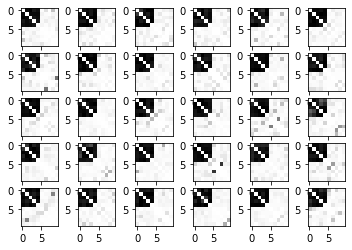

In [18]:
for i in range(30):
    plt.subplot(5, 6, i+1)
    plt.imshow(generated_from_simu[i], cmap="Greys")

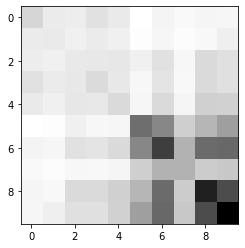

In [41]:
import matplotlib.pyplot as plt
z = torch.from_numpy(node_mu_list.reshape((n_node,out_channels)))
model.decode(z, edge_index)
adj_mat = np.zeros((n_node, n_node))
for i in range(n_node*n_node):
    adj_mat[int(edge_index[0, i]), int(edge_index[1, i])] = (model.decode(z, edge_index)[i].detach().numpy()).item()
plt.imshow(adj_mat, cmap="Greys")

In [42]:
z

tensor([[ 0.0077, -0.0375, -0.0298, -0.0042,  0.0279,  0.0312, -0.0005, -0.0173,
         -0.0148,  0.0024],
        [ 0.0119, -0.0202, -0.0238, -0.0074,  0.0102,  0.0060, -0.0051,  0.0046,
          0.0073, -0.0240],
        [-0.0066, -0.0348, -0.0053,  0.0109,  0.0105,  0.0114, -0.0038,  0.0225,
          0.0041, -0.0029],
        [-0.0061, -0.0323, -0.0089, -0.0040,  0.0349,  0.0349, -0.0058,  0.0120,
          0.0032, -0.0137],
        [-0.0059, -0.0448, -0.0139, -0.0096,  0.0033,  0.0066,  0.0052,  0.0384,
         -0.0151,  0.0073],
        [-0.0485, -0.0122,  0.0249,  0.0402,  0.0382, -0.0423,  0.0563,  0.0089,
          0.0491,  0.0243],
        [-0.0429, -0.0372,  0.0077,  0.0084,  0.0810, -0.0452,  0.0261,  0.0631,
          0.0196,  0.0344],
        [-0.0081, -0.0025,  0.0298, -0.0084,  0.0552, -0.0557,  0.0067,  0.0004,
         -0.0198,  0.0262],
        [-0.0188, -0.0581,  0.0728, -0.0055,  0.0547,  0.0100,  0.0177,  0.0815,
          0.0132,  0.0334],
        [-0.0074, -

In [341]:
simu_centrality_list

[array([0.4, 0.3, 0.3, 0.2, 0.4, 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0.2, 0.3, 0. , 0.2, 0.1, 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0.1, 0.1, 0.2, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0.1, 0.1, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0.3, 0.3, 0.4, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0.2, 0.2, 0.4, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0.2, 0.3, 0.3, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0.2, 0.2, 0.1, 0.1, 0.2, 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0.2, 0.1, 0.2, 0.1, 0. , 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0.1, 0.2, 0.2, 0.3, 0.2, 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0.2, 0.2, 0.3, 0.3, 0. , 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0.2, 0.1, 0.1, 0.1, 0.1, 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0. , 0.3, 0.3, 0.2, 0.2, 0. , 0. , 0. , 0. , 0. ], dtype=float32),
 array([0.2, 0. , 0.3, 0.

In [13]:
n_node = 10
temp = np.zeros((2, n_node * n_node))
for i in range(n_node):
    for j in range(n_node):
        temp[0, j + n_node*i] = j
for i in range(n_node):
    for j in range(n_node):
        temp[1, j + n_node*i] = i
edge_index = temp